In [1]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import Config
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
client=MongoClient(Config.DB_Hostname,Config.DB_Port)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


In [2]:
class Prediction_Engine:
    
    def __init__(self, data_start_date, data_end_date, prediction_date, underlying):
        
        self.data_start_date=data_start_date #2017-01-01
        self.data_end_date=data_end_date #2017-01-01
        self.prediction_date=prediction_date #2017-01-01
        self.underlying=underlying #NIFTY,BANKNIFTY
        
        #self.underlying_prices=pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}OHLC'].find())
        #self.underlying_simulated_parameters=pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}_Simulated_Parameters'].find())
        #self.vol_surface=pd.DataFrame(client[f'{Config.Data_DB}']['Vol_Surface'].find())
        #self.days_to_expiry=pd.DataFrame(client[f'{Config.Data_DB}']['Days_To_Expiry'].find())
        
        self.underlying_prices=pd.read_csv('prices.csv')
        self.underlying_simulated_parameters=pd.read_csv('param.csv')
        self.vol_surface=pd.read_csv('vol_surface.csv')
        self.days_to_expiry=pd.read_csv('days_to_expiry.csv')
        
        self.underlying_prices=self.underlying_prices.sort_values(['date','batch_id']).drop(columns=['Unnamed: 0','_id'])
        self.underlying_simulated_parameters=self.underlying_simulated_parameters.sort_values(['date','strategy_variant']).drop(columns=['Unnamed: 0','_id'])
        self.vol_surface=self.vol_surface.sort_values(['date','SYMBOL']).drop(columns=['Unnamed: 0','_id'])
        self.days_to_expiry=self.days_to_expiry.sort_values(['date']).drop(columns=['Unnamed: 0','_id'])
        
        columns_to_drop=['underlying','sim_number','strike_offset','drawdown_count', 'trade_count', 'capital', 'pnl',
       'first_drawdown_pnl', 'second_drawdown_pnl', 'taylor_sensitivity_1',
       'taylor_sensitivity_2', 'taylor_sensitivity_3', 'pos_dev', 'mov_dev',
       'prof_dev', 'pos_diff', 'mov_diff', 'prof_diff', 'pmpr_diff','variant_pnl_mean',
       'variant_positive_pnl_mean', 'variant_negative_pnl_mean',
       'variant_profit_percent', 'variant_pnl_stdev',
       'variant_positive_pnl_stdev', 'variant_negative_pnl_stdev',
       'variant_pnl_skew', 'variant_positive_pnl_skew',
       'variant_negative_pnl_skew', 'variant_pnl_kurtosis',
       'variant_positive_pnl_kurtosis', 'variant_negative_pnl_kurtosis',
       'variant_fav_drawdown_percent', 'variant_ts1_pnl_corr',
       'variant_ts2_pnl_corr', 'variant_ts3_pnl_corr', 'variant_ts1_mean',
       'variant_ts2_mean', 'variant_ts3_mean', 'variant_ts1_stdev',
       'variant_ts2_stdev', 'variant_ts3_stdev', 'variant_pdev_mean',
       'variant_mdev_mean', 'variant_prdev_mean', 'variant_pdev_stdev',
       'variant_mdev_stdev', 'variant_prdev_stdev', 'variant_pnl_pdiff_corr',
       'variant_pnl_mdiff_corr', 'variant_pnl_prdiff_corr',
       'variant_pnl_pmprdiff_corr', 'variant_ts1_pdiff_corr',
       'variant_ts1_mdiff_corr', 'variant_ts1_prdiff_corr',
       'variant_ts1_pmprdiff_corr', 'variant_ts2_pdiff_corr',
       'variant_ts2_mdiff_corr', 'variant_ts2_prdiff_corr',
       'variant_ts2_pmprdiff_corr', 'variant_ts3_pdiff_corr',
       'variant_ts3_mdiff_corr', 'variant_ts3_prdiff_corr',
       'variant_ts3_pmprdiff_corr', 'variant_pdev_pdiff_corr',
       'variant_pdev_mdiff_corr', 'variant_pdev_prdiff_corr',
       'variant_pdev_pmprdiff_corr', 'variant_mdev_pdiff_corr',
       'variant_mdev_mdiff_corr', 'variant_mdev_prdiff_corr',
       'variant_mdev_pmprdiff_corr', 'variant_prdev_pdiff_corr',
       'variant_prdev_mdiff_corr', 'variant_prdev_prdiff_corr',
       'variant_prdev_pmprdiff_corr', 'variant_ts1_pdev_corr',
       'variant_ts1_mdev_corr', 'variant_ts1_prdev_corr',
       'variant_ts2_pdev_corr', 'variant_ts2_mdev_corr',
       'variant_ts2_prdev_corr', 'variant_ts3_pdev_corr',
       'variant_ts3_mdev_corr', 'variant_ts3_prdev_corr']
        self.underlying_simulated_parameters.drop(columns=columns_to_drop,inplace=True)
        
        self.underlying_prices=self.underlying_prices[(self.underlying_prices.date>=self.data_start_date)&(self.underlying_prices.date<=self.data_end_date)]
        self.underlying_simulated_parameters=self.underlying_simulated_parameters[(self.underlying_simulated_parameters.date>=self.data_start_date)&(self.underlying_simulated_parameters.date<=self.data_end_date)]
        self.vol_surface=self.vol_surface[(self.vol_surface.date>=self.data_start_date)&(self.vol_surface.date<=self.data_end_date)]
        self.days_to_expiry=self.days_to_expiry[(self.days_to_expiry.date>=self.data_start_date)&(self.days_to_expiry.date<=self.prediction_date)]
        
        datelist1=self.days_to_expiry.date.unique()
        datelist2=self.underlying_prices.date.unique()
        datelist3=self.underlying_simulated_parameters.date.unique()
        datelist4=self.vol_surface.date.unique()
        dates_to_fill=[]
        
        for d in datelist3:
            
            if d not in datelist1 and d>=self.data_start_date and d <=self.data_end_date:
                raise Exception(f'{d} date in Params db absent in Expiry db')
            
            if d not in datelist2 and d>=self.data_start_date and d <=self.data_end_date:
                raise Exception(f'{d} date in Params db absent in OHLC db')
            
            if d not in datelist4 and d>=self.data_start_date and d <=self.data_end_date:
                raise Exception(f'{d} date in Params db absent in Vol_Surface db')

        for d in datelist1:
                        
            if d not in datelist2 and d>=self.data_start_date and d <=self.data_end_date:
                raise Exception(f'{d} date in Expiry db absent in OHLC db')
            
            if d not in datelist4 and d>=self.data_start_date and d <=self.data_end_date:
                raise Exception(f'{d} date in Expiry db absent in Vol_Surface db')

            if d not in datelist3 and d>=self.data_start_date and d <=self.data_end_date:
                dates_to_fill.append(d)
        
        self.vol_surface=self.vol_surface[self.vol_surface.date.isin(datelist1)]
        self.underlying_prices=self.underlying_prices[self.underlying_prices.date.isin(datelist1)]
        
        if len(dates_to_fill)>0:
            temp_df=[]
            for i in range(1,self.underlying_simulated_parameters.strategy_variant.max()+1):
                temp=self.underlying_simulated_parameters[self.underlying_simulated_parameters.strategy_variant==i]
                temp.set_index('date',inplace=True)
                
                for d in dates_to_fill:
                    temp.loc[d]=[np.nan]*len(temp.columns)

                temp.sort_index(inplace=True)
                temp.strategy_variant.ffill(inplace=True)
                temp.strategy_variant.bfill(inplace=True)
                temp.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')
                temp.reset_index(inplace=True)
                temp_df.append(temp)

            self.underlying_simulated_parameters=pd.concat(temp_df)
            self.underlying_simulated_parameters.sort_values(['date','strategy_variant'],inplace=True)
        
        self.underlying_simulated_parameters.strategy_variant=self.underlying_simulated_parameters.strategy_variant.astype(int)
        datelist1=self.days_to_expiry.date.unique()
        datelist2=self.underlying_prices.date.unique()
        datelist3=self.underlying_simulated_parameters.date.unique()
        datelist4=self.vol_surface.date.unique()
        
        if len(datelist1)-1==len(datelist2)==len(datelist3)==len(datelist4):
            print("Data Looks Good")
        else:
            raise Exception("Dates of Days_To_Expiry, OHLC, Param, Vol_Surfaces are unequal")
            
        self._Create_Features()
        self._Cleanup()

        
    def _Create_Features(self):
        
        self.merged_parameters=pd.DataFrame(index=self.underlying_simulated_parameters.date.unique())
        self.underlying_simulated_parameters.set_index('date',inplace=True)
        
        sim_vols=pd.merge(self.underlying_simulated_parameters[self.underlying_simulated_parameters.strategy_variant==1],
                              self.underlying_simulated_parameters[self.underlying_simulated_parameters.strategy_variant==13],
                              left_index=True,right_index=True)
        sim_vols=sim_vols[['sim_vol_x','sim_vol_y']]
        sim_vols.columns=['current_vol','next_vol']
        
        for i in range(1,self.underlying_simulated_parameters.strategy_variant.max()+1):
            temp=self.underlying_simulated_parameters[self.underlying_simulated_parameters.strategy_variant==i].drop(columns=['strategy_variant','sim_vol'])
            cols=temp.columns
            temp.columns=[f'{i}_' + col for col in cols]
            self.merged_parameters=pd.merge(self.merged_parameters,temp,left_index=True,right_index=True)
            
        self.params_cols=self.merged_parameters.columns
        self.merged_parameters=pd.merge(self.merged_parameters,sim_vols,left_index=True,right_index=True)
        
        merged_surfaces=pd.DataFrame(index=self.vol_surface.date.unique())
        for sym in ["NIFTY"]:#self.vol_surface.SYMBOL.unique():
            temp=self.vol_surface[self.vol_surface.SYMBOL==sym].drop(columns=['SYMBOL']).set_index('date')
            cols=temp.columns
            temp.columns=[f'{sym}_' + col for col in cols]
            merged_surfaces=pd.merge(merged_surfaces,temp,left_index=True,right_index=True)

        self.vol_cols=temp.columns
        
        self.merged_parameters=pd.merge(self.merged_parameters,merged_surfaces,left_index=True,right_index=True)
        
        temp=pd.DataFrame(index=self.underlying_prices.date.unique())
        temp["daily_range"]=(self.underlying_prices.groupby('date').max())["high"]/(self.underlying_prices.groupby('date').min())["low"]-1
        temp["daily_return"]=self.underlying_prices.groupby('date').tail(1).set_index('date').close.pct_change()
        self.underlying_prices["minute_range"]=self.underlying_prices.high/self.underlying_prices.low-1
        self.underlying_prices["minute_return"]=self.underlying_prices.close/self.underlying_prices.open-1
        temp=pd.merge(temp,self.underlying_prices.groupby('date').mean()[['minute_range','minute_return']],left_index=True,right_index=True)
        temp_=self.underlying_prices.groupby('date').std()[['minute_range','minute_return']]
        temp_.columns=['range_std','return_std']
        temp=pd.merge(temp,temp_,left_index=True,right_index=True)
        temp.minute_range=np.where(temp.range_std.isna(),np.nan,temp.minute_range)
        temp.minute_return=np.where(temp.range_std.isna(),np.nan,temp.minute_return)
        temp.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')
        
        self.underlying_cols=temp.columns

        self.merged_parameters=pd.merge(self.merged_parameters,temp,left_index=True,right_index=True)
        self.underlying_prices.drop(columns=['minute_range','minute_return'],inplace=True)
        
        lag_5_curr_map, lag_10_curr_map, lag_5_next_map, lag_10_next_map = self._Get_Lagged_Maps()

        temp_cols=[]
        temp_dict={}

        for col in self.params_cols:
            mod_check=(int(col[:col.find('_')]))
            if mod_check%24>12 or mod_check%24==0:
                temp_cols.append(col)
            else:
                temp_dict[col]=str(mod_check+12)+col[col.find('_'):]

        temp_cols+=['next_vol']
        temp_dict['current_vol']='next_vol'        

        merged_params_lagged_5=pd.DataFrame(columns=self.merged_parameters.columns)

        for k,v in lag_5_curr_map.items():
            try:
                merged_params_lagged_5.loc[k]=self.merged_parameters.loc[v]
            except:
                merged_params_lagged_5.loc[k]=[np.nan]*len(merged_params_lagged_5.columns)

        temp_df=pd.DataFrame(columns=self.merged_parameters.columns)
        for k,v in lag_5_next_map.items():
            try:
                temp_df.loc[k]=self.merged_parameters.loc[v]
            except:
                temp_df.loc[k]=[np.nan]*len(temp_df.columns)

        for col in temp_cols:
            merged_params_lagged_5[col]=temp_df[col]

        merged_params_lagged_10=pd.DataFrame(columns=self.merged_parameters.columns)

        for k,v in lag_10_curr_map.items():
            try:
                merged_params_lagged_10.loc[k]=self.merged_parameters.loc[v]
            except:
                merged_params_lagged_10.loc[k]=[np.nan]*len(merged_params_lagged_10.columns)

        temp_df=pd.DataFrame(columns=self.merged_parameters.columns)
        for k,v in lag_10_next_map.items():
            try:
                temp_df.loc[k]=self.merged_parameters.loc[v]
            except:
                temp_df.loc[k]=[np.nan]*len(temp_df.columns)

        for col in temp_cols:
            merged_params_lagged_10[col]=temp_df[col]

        self.merged_parameters.loc[self.prediction_date]=[np.nan]*len(self.merged_parameters.columns) 

        merged_params_lagged_1=self.merged_parameters.shift()
        merged_params_lagged_1["expiry_switch"]=pd.Series(np.where(self.days_to_expiry.current_week==1,1,0),index=self.days_to_expiry.date).shift().fillna(0)

        sub1=merged_params_lagged_1[merged_params_lagged_1.expiry_switch==1]
        sub2=merged_params_lagged_1[merged_params_lagged_1.expiry_switch==0]

        for k,v in temp_dict.items():
            sub1[k]=sub1[v]

        merged_params_lagged_1=pd.concat([sub1,sub2]).sort_index().drop(columns=['expiry_switch'])

        merged_params_lagged_2=self.merged_parameters.shift(2)
        merged_params_lagged_3=self.merged_parameters.shift(3)
        merged_params_lagged_4=self.merged_parameters.shift(4)

        merged_params_diffed_0=self.merged_parameters-merged_params_lagged_1
        merged_params_diffed_1=merged_params_diffed_0.copy()
        merged_params_diffed_2=self.merged_parameters-merged_params_lagged_2
        merged_params_diffed_3=self.merged_parameters-merged_params_lagged_3
        merged_params_diffed_4=self.merged_parameters-merged_params_lagged_4
        merged_params_diffed_5=self.merged_parameters-merged_params_lagged_5
        merged_params_diffed_10=self.merged_parameters-merged_params_lagged_10

        merged_params_diffed_1.columns=[col+"_diffed_1" for col in merged_params_diffed_1.columns]
        merged_params_diffed_2.columns=[col+"_diffed_2" for col in merged_params_diffed_2.columns]
        merged_params_diffed_3.columns=[col+"_diffed_3" for col in merged_params_diffed_3.columns]
        merged_params_diffed_4.columns=[col+"_diffed_4" for col in merged_params_diffed_4.columns]
        merged_params_diffed_5.columns=[col+"_diffed_5" for col in merged_params_diffed_5.columns]
        merged_params_diffed_10.columns=[col+"_diffed_10" for col in merged_params_diffed_10.columns]

        self.diffed_parameters=pd.DataFrame(index=self.merged_parameters.index)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_1,left_index=True,right_index=True)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_2,left_index=True,right_index=True)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_3,left_index=True,right_index=True)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_4,left_index=True,right_index=True)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_5,left_index=True,right_index=True)
        self.diffed_parameters=pd.merge(self.diffed_parameters,merged_params_diffed_10,left_index=True,right_index=True)

        if(len(self.diffed_parameters)-len(self.diffed_parameters.dropna())==11):
            self.diffed_parameters=pd.merge(merged_params_diffed_0.shift(-1),self.diffed_parameters,left_index=True,right_index=True)
            self.diffed_parameters=self.diffed_parameters.shift()[11:]
            print("Diffed Parameters Looks Good")
        else:
            raise Exception("More rows are missing than required for diffed Parameters")
    
        merged_params_lagged_1.columns=[col+"_lagged_1" for col in merged_params_lagged_1.columns]
        merged_params_lagged_2.columns=[col+"_lagged_2" for col in merged_params_lagged_2.columns]
        merged_params_lagged_3.columns=[col+"_lagged_3" for col in merged_params_lagged_3.columns]
        merged_params_lagged_4.columns=[col+"_lagged_4" for col in merged_params_lagged_4.columns]
        merged_params_lagged_5.columns=[col+"_lagged_5" for col in merged_params_lagged_5.columns]
        merged_params_lagged_10.columns=[col+"_lagged_10" for col in merged_params_lagged_10.columns]

        self.lagged_parameters=pd.DataFrame(index=self.merged_parameters.index)
        self.lagged_parameters=pd.merge(self.lagged_parameters,self.merged_parameters,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_1,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_2,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_3,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_4,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_5,left_index=True,right_index=True)
        self.lagged_parameters=pd.merge(self.lagged_parameters,merged_params_lagged_10,left_index=True,right_index=True)

        if(len(self.lagged_parameters)-len(self.lagged_parameters.dropna())==11):
            self.lagged_parameters=self.lagged_parameters[10:]
            print("Lagged Parameters Looks Good")
        else:
            raise Exception("More rows are missing than required for Lagged Parameters")
    
    def _Get_Lagged_Maps(self):
        
        index_list=self.days_to_expiry.date.tolist()
        current_week_list=self.days_to_expiry.set_index('date').current_week
        next_week_list=self.days_to_expiry.set_index('date').next_week        
        
        value_count=current_week_list.groupby(current_week_list).count()
        current_week_values_to_fix=value_count[value_count<sum(value_count)/100].index
        value_count=next_week_list.groupby(next_week_list).count()
        next_week_values_to_fix=value_count[value_count<sum(value_count)/100].index
        current_week_list=pd.Series(np.where(current_week_list.isin(current_week_values_to_fix),np.where(current_week_list>5,current_week_list-1,current_week_list+1),current_week_list),index=index_list)
        next_week_list=pd.Series(np.where(next_week_list.isin(next_week_values_to_fix),np.where(next_week_list>5,next_week_list-1,next_week_list+1),next_week_list),index=index_list)

        self.current_week_days_to_expiry_map=dict(zip(index_list, current_week_list))
        self.next_week_days_to_expiry_map=dict(zip(index_list, next_week_list))
        
        lag_5_curr_map={}
        for i,d in enumerate(index_list):

            d_to_expiry=current_week_list[i]
            flag=False

            for j,d_ in enumerate(reversed(index_list[:i])):

                if j>40:

                    lag_5_curr_map[d]=index_list[i-5]
                    flag=True
                    break

                if current_week_list[i-j-1]==d_to_expiry:

                    lag_5_curr_map[d]=d_
                    flag=True
                    break

            if not flag:

                if i<10:
                    lag_5_curr_map[d]=pd.NA

                else:
                    lag_5_curr_map[d]=index_list[i-5]


        lag_10_curr_map={}
        for i,d in enumerate(index_list):

            d_to_expiry=current_week_list[i]
            flag=False
            first=False
            for j,d_ in enumerate(reversed(index_list[:i])):

                if j>40:

                    lag_10_curr_map[d]=index_list[i-10]
                    flag=True
                    break

                if current_week_list[i-j-1]==d_to_expiry:

                    if first:
                        lag_10_curr_map[d]=d_
                        flag=True
                        break
                    else:
                        first=True

            if not flag:

                if i<10:
                    lag_10_curr_map[d]=pd.NA

                else:
                    lag_10_curr_map[d]=index_list[i-10]


        lag_5_next_map={}
        for i,d in enumerate(index_list):

            d_to_expiry=next_week_list[i]
            flag=False

            for j,d_ in enumerate(reversed(index_list[:i])):

                if j>80:

                    lag_5_next_map[d]=index_list[i-5]
                    flag=True
                    break

                if next_week_list[i-j-1]==d_to_expiry:

                    lag_5_next_map[d]=d_
                    flag=True
                    break

            if not flag:

                if i<10:
                    lag_5_next_map[d]=pd.NA

                else:
                    lag_5_next_map[d]=index_list[i-5]


        lag_10_next_map={}
        for i,d in enumerate(index_list):

            d_to_expiry=next_week_list[i]
            flag=False
            first=False
            for j,d_ in enumerate(reversed(index_list[:i])):

                if j>80:

                    lag_10_next_map[d]=index_list[i-10]
                    flag=True
                    break

                if next_week_list[i-j-1]==d_to_expiry:

                    if first:
                        lag_10_next_map[d]=d_
                        flag=True
                        break
                    else:
                        first=True

            if not flag:

                if i<10:
                    lag_10_next_map[d]=pd.NA

                else:
                    lag_10_next_map[d]=index_list[i-10]
        
        return lag_5_curr_map, lag_10_curr_map, lag_5_next_map, lag_10_next_map

    def _Cleanup(self):
        
        self.diffed_dependent=self.diffed_parameters[self.params_cols]
        self.lagged_dependent=self.lagged_parameters[self.params_cols]

        temp_cols=[]
        for col in self.diffed_parameters.columns:
            if col.find('diffed')==-1:
                temp_cols.append(col)
            else:
                break

        self.diffed_independent_real=self.diffed_parameters.loc[:, ~self.diffed_parameters.columns.isin(temp_cols)]
        self.lagged_independent_real=self.lagged_parameters.loc[:, ~self.lagged_parameters.columns.isin(temp_cols)]

        self.lagged_independent_categorical=pd.DataFrame(index=self.lagged_independent_real.index)
        self.diffed_independent_categorical=pd.DataFrame(index=self.diffed_independent_real.index)

        self.lagged_independent_categorical["current_week"]=self.lagged_independent_categorical.index.map(self.current_week_days_to_expiry_map)
        self.lagged_independent_categorical["next_week"]=self.lagged_independent_categorical.index.map(self.next_week_days_to_expiry_map)
        self.diffed_independent_categorical["current_week"]=self.diffed_independent_categorical.index.map(self.current_week_days_to_expiry_map)
        self.diffed_independent_categorical["next_week"]=self.diffed_independent_categorical.index.map(self.next_week_days_to_expiry_map)

        self.lagged_independent_categorical["NIFTY_Weekly_Flag"]=np.where(self.lagged_independent_categorical.index>="2019-02-11",1,0)
        self.diffed_independent_categorical["NIFTY_Weekly_Flag"]=np.where(self.diffed_independent_categorical.index>="2019-02-11",1,0)
        
        self.diffed_independent_categorical=pd.get_dummies(self.diffed_independent_categorical,
                                                           columns=self.diffed_independent_categorical.columns[:-1])
        self.lagged_independent_categorical=pd.get_dummies(self.lagged_independent_categorical,
                                                           columns=self.lagged_independent_categorical.columns[:-1])        

        
        del self.diffed_parameters
        del self.lagged_parameters
        del self.current_week_days_to_expiry_map
        del self.next_week_days_to_expiry_map
        del self.params_cols
        del self.underlying_cols
        del self.underlying_prices
        del self.underlying_simulated_parameters
        del self.vol_cols
        del self.vol_surface

In [3]:
class Test:
    
    def __init__(self):
        self.P=Prediction_Engine('2017-01-02','2023-04-13','2023-04-17','NIFTY')
        self.data_end_date=self.P.data_end_date
        self.data_start_date=self.P.data_start_date
        self.days_to_expiry=self.P.days_to_expiry
        self.diffed_dependent=self.P.diffed_dependent
        self.diffed_independent_categorical=self.P.diffed_independent_categorical
        self.diffed_independent_real=self.P.diffed_independent_real
        self.lagged_dependent=self.P.lagged_dependent
        self.lagged_independent_categorical=self.P.lagged_independent_categorical
        self.lagged_independent_real=self.P.lagged_independent_real
        self.merged_parameters=self.P.merged_parameters
        self.prediction_date=self.P.prediction_date
        self.underlying=self.P.underlying        

In [4]:
self=Test()

Data Looks Good
Diffed Parameters Looks Good
Lagged Parameters Looks Good


In [14]:
import pmdarima as pm

<Axes: >

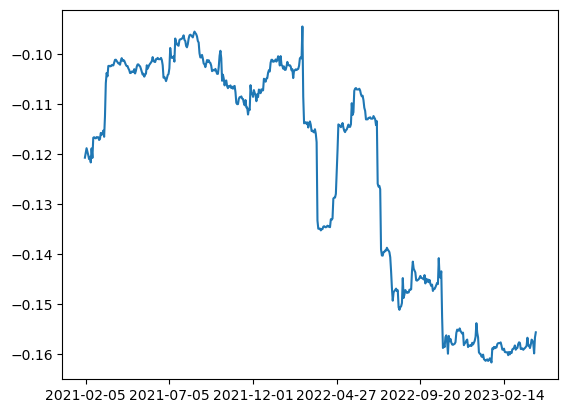

In [521]:
self.diffed_dependent['1_pos_param'].rolling(1000).apply(lambda x: x.autocorr(), raw=False).plot()

In [1010]:
m=451
n=200
res = pm.auto_arima(self.diffed_dependent['34_mov_param'][m:m+n])

In [1011]:
np.mean(np.abs(res.resid()))

0.01580473121445912

In [1012]:
np.mean(np.abs(self.diffed_dependent['34_mov_param'][m:m+n]))

0.015899999999999997

In [1013]:
res.predict(1)

/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


200    0.006999
dtype: float64

In [1014]:
self.diffed_dependent['34_mov_param'][m+n]

-0.009999999999999953

In [5]:
temp_cols=[]
for col in self.diffed_independent_real.columns:
#    if col.find('pos_param')==-1 and col.find('mov_param')==-1 and col.find('prof_param')==-1 and col.endswith('diffed_1'):
    if col.endswith('diffed_1') or col.endswith('diffed_5'):

        temp_cols.append(col)

self.diffed_independent_real=self.diffed_independent_real.loc[:, self.diffed_independent_real.columns.isin(temp_cols)]

temp_cols=[]
for col in self.lagged_independent_real.columns:
#    if col.find('pos_param')==-1 and col.find('mov_param')==-1 and col.find('prof_param')==-1 and col.endswith('lagged_1'):
    if col.endswith('lagged_1') or col.endswith('lagged_5'):

        temp_cols.append(col)

self.lagged_independent_real=self.lagged_independent_real.loc[:, self.lagged_independent_real.columns.isin(temp_cols)]

In [5]:
import pmdarima as pm

In [292]:
col='6_prof_param'
res=pm.auto_arima(self.diffed_dependent[col][-120:].dropna())

In [293]:
res

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

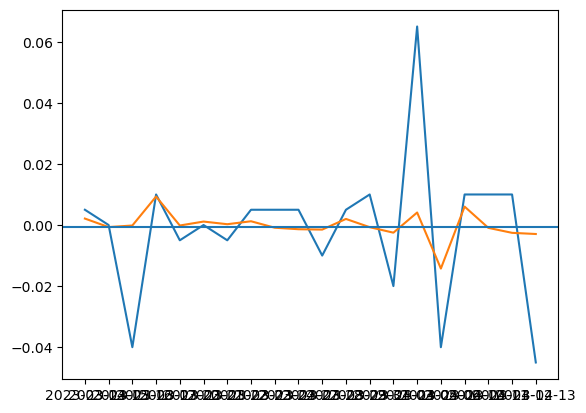

In [294]:
plt.plot(self.diffed_dependent[col].dropna().tolist()[-20:])
plt.plot(res.fittedvalues()[-20:])
plt.axhline(y=self.diffed_dependent[col].dropna().mean())

In [295]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [296]:
r2_score(self.diffed_dependent[col].dropna().tolist()[-100:],res.fittedvalues()[-100:])

0.012958440526016468

In [297]:
r2_score(self.diffed_dependent[col].dropna().tolist()[-100:],[self.diffed_dependent[col].dropna().mean()]*100)

-0.0074058151869969

In [298]:
np.abs(res.resid()[-100:]).mean()

0.01271204931797077

In [299]:
np.abs(self.diffed_dependent[col][-100:]).mean()

0.012525252525252523

In [253]:
self.diffed_dependent[col][-100:].mean()

-5.050505050505055e-05

In [8]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [9]:
y_train=self.diffed_dependent[:-100].values
y_test=self.diffed_dependent[:-1].values
X_train=self.diffed_independent_real[:-100].values
X_test=self.diffed_independent_real[:-1].values
categorical_test=self.diffed_independent_categorical[:-100].values
categorical_train=self.diffed_independent_categorical[:-1].values

In [10]:
y_train=self.lagged_dependent[:-100].values
y_test=self.lagged_dependent[:-1].values
X_train=self.lagged_independent_real[:-100].values
X_test=self.lagged_independent_real[:-1].values
categorical_test=self.lagged_independent_categorical[:-100].values
categorical_train=self.lagged_independent_categorical[:-1].values

In [11]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)
X_test=sc_X.transform(X_test)
y_test=sc_y.transform(y_test)

In [12]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: pd.Period(self.data_start_date,freq='D'),
            FieldName.FEAT_DYNAMIC_REAL: X_train.T,
            #FieldName.FEAT_DYNAMIC_CAT: categorical_train.T
        }
        for target in y_train.T
    ],
    freq="D",
)


In [13]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: pd.Period(self.data_start_date,freq='D'),
            FieldName.FEAT_DYNAMIC_REAL: X_test.T,
            #FieldName.FEAT_DYNAMIC_CAT: categorical_test.T
        }
        for target in y_test.T
    ],
    freq="D",
)


In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

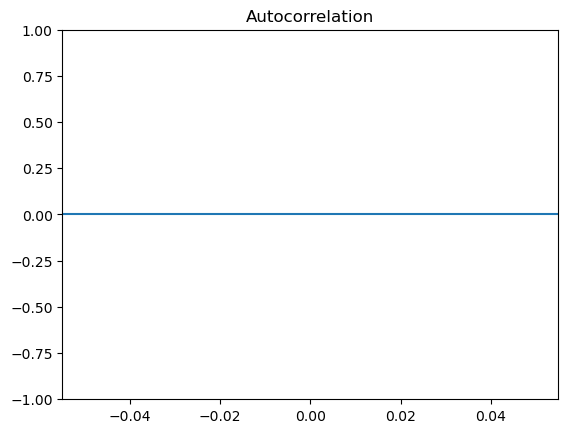

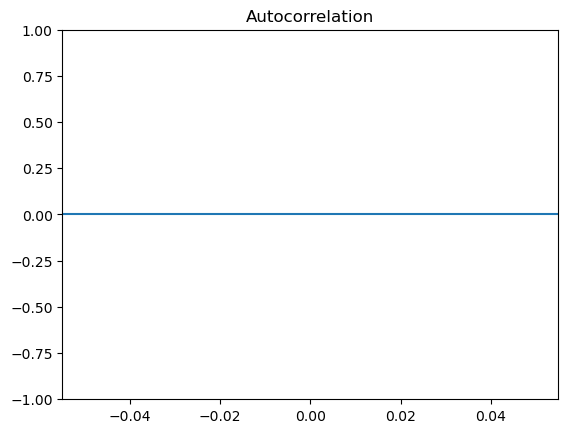

In [30]:
self.diffed_dependent['123_pos_param'].values.ravel())

In [18]:
from gluonts.mx import DeepStateEstimator, Trainer

OSError: dlopen(/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so, 0x0006): tried: '/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (no such file), '/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (not a mach-o file)

In [19]:
import gluonts.mx.model.deepstate.issm as iss

OSError: dlopen(/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so, 0x0006): tried: '/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (no such file), '/Users/praneetshaw/anaconda3/lib/python3.10/site-packages/mxnet/libmxnet.so' (not a mach-o file)

In [ ]:
estimator=DeepStateEstimator(freq= 'D', prediction_length= 99, cardinality= [2]*len(categorical_test[0]),
add_trend = True,
num_periods_to_train = 10, #past_length,
trainer = Trainer(
add_default_callbacks=True, callbacks=None, clip_gradient=10.0, 
ctx='cpu', epochs=1000, hybridize=True, init='xavier', 
learning_rate=0.001, num_batches_per_epoch=50, 
weight_decay=1e-04),
num_layers = 5, 
num_cells = 7, 
cell_type = 'lstm', 
num_parallel_samples = 1000, dropout_rate = 0.2, 
use_feat_dynamic_real = False,
use_feat_static_cat = False,
#embedding_dimension: Optional[List[int]] = None, 
#issm= iss.LevelISSM(),
scaling = False, 
#time_features: Optional[List[Callable[[pandas.core.indexes.period.PeriodIndex], numpy.ndarray]]] = None,
#noise_std_bounds: gluonts.mx.distribution.lds.ParameterBounds = gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), 
#prior_cov_bounds: gluonts.mx.distribution.lds.ParameterBounds = gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), 
#innovation_bounds: gluonts.mx.distribution.lds.ParameterBounds = gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=0.01), 
batch_size = 32)

In [ ]:
predictor = estimator.train(train_ds)

In [348]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import Config
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
client=MongoClient(Config.DB_Hostname,Config.DB_Port)


In [349]:
df=pd.DataFrame(client.Strategy.NIFTY_Predicted_Parameters.find())

In [350]:
df["flag"]=np.where(df.second_drawdown_pnl>=0,1,0)

In [382]:
n=200000
df[n:n+3840].groupby('strategy_variant').mean().PnL.idxmax()

80

In [352]:
df.groupby('strategy_variant').mean().second_drawdown_pnl.max()

-679.6826408053438

In [381]:
df[df.strategy_variant==48].PnL[520:530].mean()

715.3925948666581

In [376]:
200000/384

520.8333333333334